# プログラムの実行効率向上

Pythonの動的特性はプログラムの開発を便利にしますが、プログラムの実行速度を大幅に低下させることもあります。特に計算集約型のプログラムでは、PythonプログラムとC言語プログラムの実行効率には数十倍から数百倍の差が生じることがあります。

そのため、Pythonで計算クラスのプログラムを開発する際には、通常、NumPyやSciPyなどのコンパイル型言語で書かれた拡張ライブラリを呼び出し、Python内で大量のループや数値計算を直接行うことを避けます。これらの既存のライブラリが計算要件を満たせない場合、より効率的な言語でコア計算部分を書き、それにPythonの呼び出しインターフェースを提供することで、効率的な開発と効率的な計算を同時に実現します。

しかし、C言語で直接拡張ライブラリを書くと、Pythonが提供するすべての利便性を失います：関数のパラメータを手動で解析する必要があり、オブジェクトの参照カウントを手動で管理し、大量のPython/C API関数を覚える必要があります。これらの困難さにより、開発者は実際の問題解決に集中することができません。

本章では、Julia集合の計算を最適化することで、CFFI、ctypes、Cython、Numbaなどのさまざまな拡張ライブラリを使用してプログラムの計算速度を向上させる方法を紹介します。本書の後続の章では、CFFI、Cython、Numbaの使用方法について詳しく説明します。読者が本章で紹介するさまざまな高速化方法を習得すれば、Pythonプログラムの実行効率を心配する必要はなくなります。

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Pythonの計算が遅い理由

Pythonプログラムの実行効率に影響を与える主な理由は2つあります：

1. PythonオブジェクトはC言語のデータをラップしています。このラップにより、各オブジェクト内で実際にデータを保存するアドレスが連続していないため、CPUのキャッシュ最適化に不利です。NumPyが提供する`ndarray`配列はこの問題を完璧に解決します。

2. PythonプログラムはPython仮想マシンで実行されます。どんな小さな計算ステップでも、複数のPython/C API関数を呼び出す必要があります。そのため、ループ内で大量にPython関数を呼び出す必要がある場合、関数の呼び出しコストは数値計算部分よりも大きくなります。NumPyが提供する`ufunc`関数は、C言語でループを実装することで計算効率の問題を解決します。

### Pythonオブジェクト

Python言語の動的特性により、Pythonでは整数でさえもオブジェクトとしてメモリに保存されます。これには、オブジェクトの型やガベージコレクション用の参照カウンタなどの情報を追加で保存する必要があります。以下のプログラムから、Pythonでは整数オブジェクトが28バイトを占有することがわかります。一方、コンパイル型言語では、16ビット、32ビット、64ビットなど、必要なタイプの整数を使用できます。

In [2]:
import sys

aint = 10000
sys.getsizeof(aint)

28

`sys.getrefcount()`を使用して、オブジェクトの参照カウントを確認できます。以下では、まず`aint`オブジェクトの参照カウントを表示し、次にリスト`alist`を作成して`aint`を10回参照し、最後に`del`キーワードを使用して`alist`を削除します。出力から、`aint`オブジェクトの参照カウントの変化を確認できます。この例から、Pythonのリストオブジェクトには他のオブジェクトの参照が保存されていることがわかります。そのため、整数リストでは、すべての整数のバイナリデータを実際に保存するメモリアドレスは連続していません。これは、CPUのキャッシュ最適化に不利です。

In [3]:
print(sys.getrefcount(aint))
alist = [aint] * 10
print(sys.getrefcount(aint))
del alist
print(sys.getrefcount(aint))

2
12
2


NumPyの章で紹介したように、NumPy配列を使用してデータを保存する場合、すべてのデータを一つの連続したメモリ領域に保存できます。ただし、その中の特定の要素をPythonで計算する必要がある場合、その要素をPythonオブジェクトにラップする必要があります。このプロセスはボクシング(boxing)と呼ばれ、その逆はアンボクシング(unboxing)と呼ばれます。

以下の例では、リストから取り出された要素はオブジェクトそのものであり、2回のインデックス操作で同じオブジェクトを取得します。一方、配列から要素を取得する場合、ボクシング操作が必要で、毎回新しいPythonオブジェクトが作成されます。Pythonでは`is`キーワードを使用して、2つの参照が同じオブジェクトを指しているかどうかを判断します。各参照とオブジェクトのメモリ内の関係は次のグラフに示されています。Pythonは実際の数値計算を行う前に、さまざまな参照、ボクシング、アンボクシングなどの操作を完了する必要があります。これがPythonの数値計算速度が遅い理由の1つです。

![オブジェクトの参照とボクシングの図](images/python-reference.svg)

In [4]:
import numpy as np

alist = [1000, 1001, 1002]
arr = np.array(alist)
a = alist[1]
b = alist[1]
c = arr[1]
d = arr[1]
print(a is b)
print(c is d)

True
False


### Pythonインタプリタ

PythonプログラムはPython仮想マシンで実行されます。Pythonはプログラムを実行する際、まずコンパイラを呼び出してソースコードをバイトコードにコンパイルし、次にインタプリタでそのバイトコードを実行します。Pythonインタプリタはスタック仮想マシンであり、スタックを使用して仮想マシンの状態を保存します。`dis`モジュールを使用して、Python関数のバイトコードを表示できます。以下のプログラムは、`hypot()`のバイトコードを表示します。`hypot()`の計算を完了するために、仮想マシンは10個のバイトコードを実行する必要があります。`LOAD_FAST`と`LOAD_CONST`はそれぞれローカル変数と定数オブジェクトをスタックにプッシュし、`BINARY_POWER`と`BINARY_ADD`はスタックの最上位の2つのオブジェクトに対してべき乗演算と加算演算を行い、その結果をスタックにプッシュします。

In [5]:
import dis


def hypot(a, b):
    return (a**2 + b**2) ** 0.5


dis.dis(hypot)

  4           RESUME                   0

  5           LOAD_FAST                0 (a)
              LOAD_CONST               1 (2)
              BINARY_OP                8 (**)
              LOAD_FAST                1 (b)
              LOAD_CONST               1 (2)
              BINARY_OP                8 (**)
              BINARY_OP                0 (+)
              LOAD_CONST               2 (0.5)
              BINARY_OP                8 (**)
              RETURN_VALUE


バイトコードを実行する仮想マシンのC言語ソースプログラムは`ceval.c`であり、各バイトコードコマンドに対応するC言語プログラムが含まれています。以下のリンクを使用してそのソースプログラムを確認できます。

:::{seealso}
https://github.com/python/cpython/blob/master/Python/ceval.c

Pythonバイトコードを実行するC言語ソースプログラム
:::

以下に、`LOAD_FAST`と`BINARY_ADD`コマンドに対応するC言語プログラムを示します。各バイトコードコマンドは、C言語プログラムの一部を実行する必要があることがわかります。加算計算のコードでは、まず演算対象が文字列オブジェクトかどうかを判断し、もしそうであれば文字列連結関数`unicode_concatenate()`を呼び出し、そうでなければ`PyNumber_Add()`関数を呼び出します。`PyNumber_Add()`の実行をさらに追跡すると、2つの浮動小数点数の合計を実際に計算するために多くのコードを実行する必要があることがわかります。

```c
case TARGET(LOAD_FAST): {
    PyObject *value = GETLOCAL(oparg);
    if (value == NULL) {
        format_exc_check_arg(tstate, PyExc_UnboundLocalError,
                             UNBOUNDLOCAL_ERROR_MSG,
                             PyTuple_GetItem(co->co_varnames, oparg));
        goto error;
    }
    Py_INCREF(value);
    PUSH(value);
    FAST_DISPATCH();
}
```

```c
case TARGET(BINARY_ADD): {
    PyObject *right = POP();
    PyObject *left = TOP();
    PyObject *sum;
    if (PyUnicode_CheckExact(left) &&
             PyUnicode_CheckExact(right)) {
        sum = unicode_concatenate(tstate, left, right, f, next_instr);
    }
    else {
        sum = PyNumber_Add(left, right);
        Py_DECREF(left);
    }
    Py_DECREF(right);
    SET_TOP(sum);
    if (sum == NULL)
        goto error;
    DISPATCH();
}
```

## C言語コンパイラの設定

プログラムの実行速度を向上させるためには、コンパイラを使用して効率的な計算プログラムをマシンコードにコンパイルする必要があります。本書では、cffi、Cython、Numbaの3つの拡張ライブラリを使用してプログラムの計算速度を向上させる方法を紹介します。まず、以下の`conda`コマンドを使用して、cffi、Cython、Numbaなどの拡張ライブラリをインストールします。

```
conda install cython numba cffi
```

`cffi`または`Cython`を使用して拡張モジュールをコンパイルするためには、優先するC言語コンパイラを設定する必要があります。Pythonは`distutils`を使用して拡張ライブラリをコンパイルし、`distutils`は3つの設定ファイルからコンパイルオプションを読み取ります。これらの設定ファイルは以下の通りで、優先順位が上がります。

1. `distutils`モジュールのパスにある`distutils.cfg`ファイル。
2. ユーザーのホームディレクトリにある`pydistutils.cfg`ファイル。
3. 現在のパスにある`setup.cfg`ファイル。

以下のプログラムは、上記の3つのファイルのパスを表示し、`parse_config_files()`を呼び出して設定を読み込みます。出力から、`build`コマンドの`compiler`オプションが`mingw32`に設定されていることがわかります。この設定は`setup.cfg`ファイルから読み込まれます。以下はそのファイルの内容です：

```
[build]
compiler=mingw32
```

:::{seealso}
https://github.com/niXman/mingw-builds-binaries
MinGW-W64のインストーラーでインストールした後、`gcc.exe` のあるフォルダーのパスを PATH 環境変数に追加してください。
:::

In [6]:
from distutils.core import Distribution

dist = Distribution()
print(dist.find_config_files())
dist.parse_config_files()
dist.command_options

['setup.cfg']


{'build': {'compiler': ('setup.cfg', 'mingw32')},
 'build_ext': {'compiler': ('setup.cfg', 'mingw32')}}

## Julia集合の計算最適化

Julia集合は、複素平面上でフラクタルを形成する点の集合です。以下の式を反復して得られます：

$$ f_{c}(z)=z^{2}+c$$

固定された複素数$c$に対して、ある複素数$z_{0}$を取ると、次のシーケンスが得られます：

$$ z_{0},f_{c}(z_{0}),f_{c}(f_{c}(z_{0})),f_{c}(f_{c}(f_{c}(z_{0}))),\ldots .$$

このシーケンスは無限大に発散するか、ある範囲内にとどまり、ある値に収束する可能性があります。発散しない$z_0$値の集合をJulia集合と呼びます。ランダム逆反復アルゴリズムを使用して、Julia集合上の点を計算できます。その具体的なアルゴリズムは以下の通りで、$z_n$と$c$はどちらも複素数です。

1. $z_{0} ={\frac  {1+{\sqrt  {1-4c}}}{2}}$で初期化します。
2. $z_{n} = \sqrt{z_{n-1} - c}$を計算します。
3. 二分の一の確率で$z_{n}$の符号を変更します。
4. $z_{n}$を保存し、ステップ2を繰り返します。

この反復アルゴリズムは、NumPyが提供する`ufunc`では実装できず、ループを使用して各反復の結果を計算する必要があります。以下の`py_julia_set()`は上記の計算を実装しており、`cmath`はPython標準ライブラリで複素数計算を行うモジュールです。

In [7]:
import numpy as np
import cmath
import random


def py_julia_set(c, n):
    z = (1 + cmath.sqrt(1 - 4 * c)) / 2
    res = np.zeros(n, dtype=np.complex128)
    for i in range(n):
        z = cmath.sqrt(z - c)
        if random.randint(0, 1):
            z = -z
        res[i] = z
    return res


c = -0.512511498387847167 + 0.521295573094847167j
%timeit py_julia_set(c, 100000)
z = py_julia_set(c, 100000)

106 ms ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


`z` は複素数の配列です。次のコードでは、`z` の実数部分と虚数部分を取り出し、`histogram2d()` を使用して 2 次元ヒストグラムを計算し、可視化します。  

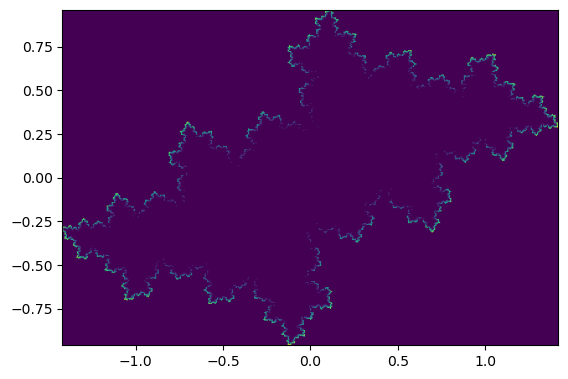

In [8]:
counts, xe, ye = np.histogram2d(z.real, z.imag, bins=400)
plt.imshow(np.log(counts.T + 1), extent=[xe[0], xe[-1], ye[0], ye[-1]]);

### C言語関数の呼び出し

以下の`julia.c`ファイルの`julia_set()`は、`py_julia_set()`と同じ計算を実装しています。Pythonの外部関数呼び出しモジュールCFFIとctypesは複素数型の値をパラメータとしてサポートしていないため、ここでは`cr`と`ci`パラメータを使用して複素数$c$の実部と虚部をそれぞれ渡します。C言語関数内ではNumPy配列を作成できないため、ここでは複素数ポインタ`arr`を使用して結果を出力し、`n`はその配列の長さです。

In [9]:
%%file julia.c
#include <complex.h>
#include <stdlib.h>

void julia_set(double cr, double ci, double complex * arr, int n)
{
    int i;
    double complex c;
    double complex z;
    c = cr + ci * I;
    z = 0.0;
    for(i=0; i<n; i++){
        z = csqrt(z - c);
        if(rand() & 0x01){
            z = -z;
        }
        arr[i] = z;
    }
}

Overwriting julia.c


以下のコマンドを呼び出すと、`julia.c`をダイナミックリンクライブラリ`julia.dll`にコンパイルし、その中で定義されたすべての関数をエクスポートできます。

In [10]:
!gcc -shared julia.c -o julia.dll

以下では、CFFIモジュールを使用して`julia.dll`内の`julia_set()`関数を呼び出します。❶まず、`FFI`オブジェクトを作成します。FFIは「Foreign Function Interface」（外部関数インターフェース）の略です。❷その`cdef()`メソッドを呼び出して、ダイナミックリンクライブラリ内の外部関数の型を宣言します。CFFIモジュールは複素数型をサポートしていないため、`arr`ポインタ型を`double *`として宣言します。ポインタ引数はアドレスを渡すため、関数呼び出し時に渡すポインタ型は重要ではありません。`julia_set()`内部では、`arr`のアドレス値を複素数ポインタとして処理します。❸`dlopen()`メソッドを呼び出してダイナミックリンクライブラリ`julia.dll`を開き、外部関数ライブラリを表すオブジェクト`lib`を取得します。これを使用して、`cdef()`で宣言されたすべての外部関数をPythonから呼び出すことができます。

❹外部関数を呼び出す際、CFFIは自動的にPythonのオブジェクトを対応するC言語の型データに変換します。例えば、`float`オブジェクトは`double`型の数値に、`int`オブジェクトは`int`型の数値に変換されます。CFFIはNumPy配列を自動的に変換できないため、ここでは`ffi.from_buffer()`を呼び出してNumPy配列をそのデータストレージ領域へのポインタに変換します。ポインタの型は最初の引数で指定されます。NumPy配列を外部関数に渡す際、外部関数は配列の`shape`や`strides`などの属性を取得できないことに注意する必要があります。`lib.julia_set()`に渡す配列が1次元で連続したストレージであることを確認する必要があります。

In [11]:
import cffi

ffi = cffi.FFI()  #❶
ffi.cdef("void julia_set(double cr, double ci, double * arr, int n);")  #❷
lib = ffi.dlopen("julia.dll")  #❸


def cffi_julia_set(c, n):
    res = np.zeros(n, dtype=np.complex128)
    lib.julia_set(c.real, c.imag, ffi.from_buffer("double *", res), len(res))  #❹
    return res


%timeit cffi_julia_set(c, 100000)

6.34 ms ± 81.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Pythonの標準ライブラリctypesを使用して外部関数を呼び出すこともできます。ctypesの使用手順はCFFIとは逆で、まず`ctypes.cdll.LoadLibrary()`を使用してダイナミックリンクライブラリをロードし、次に外部関数の`argtypes`および`restype`属性を使用してそのパラメータ型および戻り値型を設定します。NumPy配列の`ctypes.data_as()`メソッドを使用して、ctypesのポインタオブジェクトに変換できます。

In [12]:
import ctypes
from ctypes import c_double, POINTER, c_int

dll = ctypes.cdll.LoadLibrary("julia.dll")
dll.julia_set.argtypes = [c_double, c_double, POINTER(c_double), c_int]
dll.julia_set.restype = None
res = np.zeros(10000, np.complex128)
dll.julia_set(c.real, c.imag, res.ctypes.data_as(POINTER(c_double)), len(res))

### Cythonで計算速度向上

Cythonは、C言語でPython拡張モジュールを書く負担を軽減するために開発されたプログラミング言語です。その構文は基本的にPythonと同じですが、C言語の関数を直接定義および呼び出したり、変数の型を定義したりする機能が追加されています。Cythonのコンパイラを使用して、CythonのソースプログラムをC言語のソースプログラムにコンパイルし、さらにC言語コンパイラを使用して拡張モジュールにコンパイルできます。Cythonプログラムは、C言語の計算速度を実現しつつ、Pythonのすべての動的特性を使用できるため、拡張ライブラリの作成が非常に便利になります。

Cython言語はPythonに`cimport`、`cdef`、`extern from`などのキーワードを追加し、`wraparound`、`boundscheck`などのコンパイルディレクティブを使用してコンパイラの動作を制御できます。Cythonプログラムでは、Pythonオブジェクトを処理できるだけでなく、`cdef`を使用してC言語の型の変数や関数を定義できます。これにより、Python/C APIを呼び出す必要があったループを、C言語の関数のみを呼び出し、C言語のデータ型のみを処理するループにコンパイルできます。Cythonプログラムは、Pythonプログラムの柔軟性とC言語プログラムの高性能を同時に実現できます。

Notebookでは、`%%cython`マジックコマンドを使用して拡張モジュールをコンパイルし、同時にそのモジュールで定義された関数をロードできます。このマジックコマンドは、`%load_ext cython`を使用してロードする必要があります。以下のプログラムは`%%cython`コマンドで始まり、Cythonプログラムであることを示しています。`cy_julia_set()`関数では、NumPyの`zeros()`を使用して配列を作成し、C言語関数ライブラリの`csqrt()`および`rand()`関数を呼び出しています。`rand()`は`cimport`キーワードを使用して`lib.stdlib`からロードし、`csqrt()`はC言語のヘッダファイル'complex.h'から直接ロードします。


:::{warning}
[https://github.com/cython/cython/issues/5003](https://github.com/cython/cython/issues/5003)  
`%%cython` のバグに関する issue です。この issue が解決されるまで、次の方法で `%%cython` マジックコマンドをロードしてください。  

```
import helper.cython
%load_ext helper.cython
```
:::

In [13]:
import helper.cython
%load_ext helper.cython

In [14]:
%%cython --compile-args=-w
# distutils: define_macros=NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION
import numpy as np
cimport numpy as np
cimport cython
from libc.stdlib cimport rand

cdef extern from "complex.h":
    double complex csqrt(double complex z)

@cython.wraparound(False)
@cython.boundscheck(False)
def cy_julia_set(double complex c, int n):
    cdef double complex[::1] res
    cdef double complex z
    arr = np.zeros(n, np.complex128)
    res = arr
    z = 0
    for i in range(n):
        z = csqrt(z - c)
        if rand() & 0x01:
            z = -z
        res[i] = z
    return arr

`%%cython`マジックコマンドは、Cythonモジュールをコンパイルした後、そのモジュール内のすべての関数を現在の実行環境にロードするため、`cy_julia_set()`を直接呼び出すことができます：

In [15]:
%timeit cy_julia_set(c, 100000)

5.7 ms ± 166 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### NumbaでJITコンパイル

CFFIを使用してダイナミックリンクライブラリを呼び出す場合も、Cythonを使用して拡張モジュールをコンパイルする場合も、既存のPythonプログラムを変更し、C言語コンパイラを使用してコンパイルする必要があります。NumbaはLLVMコンパイルフレームワークを使用して実装されたジャストインタイムコンパイルライブラリで、Numbaを使用するとC言語コンパイラを必要とせずにPython関数を直接マシンコードにコンパイルしてプログラムの計算速度を向上させることができます。

以下では、`numba.jit()`を使用して前述の`py_julia_set()`関数をジャストインタイムコンパイルして`numba_julia_set()`関数に変換します。`numba_julia_set()`を初めて呼び出す際、Numbaは`py_julia_set()`をマシンコードにコンパイルします。ジャストインタイムコンパイルには時間がかかるため、`numba_julia_set()`の実行速度をテストするには、まずこの関数を一度実行してから、`%timeit`を使用してその実行時間を計算します。

In [16]:
import numba as nb

numba_julia_set = nb.jit(py_julia_set)
numba_julia_set(c, 10)
%timeit numba_julia_set(c, 100000)

5.27 ms ± 118 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


`py_julia_set()`はすべての反復点の座標を返しますが、反復回数が大きすぎると大量のメモリを消費します。この問題を解決するために、各座標付近の反復点の出現回数を返すことができます。以下の`numba_julia_set_count()`はこのアルゴリズムを実装しており、(-1.5, -1.5)から(1.5, 1.5)の領域を`resolution * resolution`のグリッドに等分割し、2次元配列`grid`を使用して各グリッドに反復点が落ちた回数を保存します。関数の前に`numba.jit`デコレータを使用すると、ジャストインタイムコンパイル後の関数を直接取得できます。

In [17]:
@nb.jit
def numba_julia_set_count(c, n, resolution=1000):
    grid = np.zeros((resolution, resolution), np.int32)
    z = 0 + 0j
    for i in range(n):
        z = cmath.sqrt(z - c)
        if random.randint(0, 1):
            z = -z
        col = int((resolution * (z.real + 1.5) / 3.0))
        row = int((resolution * (-z.imag + 1.5) / 3.0))
        if 0 <= col < resolution and 0 <= row < resolution:
            grid[row, col] += 1

    return grid

ジャストインタイムコンパイル関数の`py_func`属性を使用して、元のPython関数を取得できます。以下では、ジャストインタイムコンパイル前後の実行時間を比較します：

In [18]:
numba_julia_set_count(c, 10, 10)
%timeit numba_julia_set_count(c, 100000, 300)
%timeit numba_julia_set_count.py_func(c, 100000, 300)

4.88 ms ± 178 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
290 ms ± 4.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 反復アルゴリズムの改良

ランダムに反復点を選択する方法は簡単に実装できますが、Julia集合の各位置を均等に探索するのは難しいです。より均等に反復を行うためには、2つの反復点の両方に対して反復計算を行い、あるグリッドに落ちた回数が閾値`max_count`を超えた場合、そのグリッド内の点に対して反復計算を行わないようにします。以下の`numba_julia_set_count_miim()`はこの反復アルゴリズムを実装しています。プログラムでは、配列`p`をキューとして使用し、`j`は新しい反復点のインデックス、`i`は次に反復計算を行う点のインデックスです。`j - i`は反復待ちのキューの長さです。反復を開始する際、初期反復点を`p`のインデックス0に書き込み、この時点でキューの長さは1です。その後、ループ内でキューから1つの点を取り出して反復計算を行い、2つの点を取得します。反復点が`grid`内の対応する回数が閾値未満の場合、その点をキューに追加し、`grid`内の対応するカウントを更新します。以下のいずれかの停止条件が真になるまでこのループを続けます：

* キューの長さが0の場合、つまり`i == j`の場合；
* 反復点が`grid`の対応する範囲を超えた場合；
* インデックス`j`が配列`p`の長さに等しい場合、つまり配列`p`が満杯になった場合。

In [19]:
import numpy as np


@nb.jit
def numba_julia_set_count_miim(c, n, resolution=1000, max_count=10):
    p = np.zeros(n, np.complex128)
    grid = np.zeros((resolution, resolution), np.int32)
    j = 1
    i = 0

    z = 0 + 0j
    p[0] = z

    while True:
        if i >= j:
            break

        z = p[i]
        i += 1

        z = (z - c) ** 0.5
        zr = z.real
        zi = z.imag

        if zr <= -2 or zr >= 2 or zi <= -2 or zi >= 2:
            break

        for k in range(2):
            col = int((resolution * (z.real + 1.5) / 3.0))
            row = int((resolution * (-z.imag + 1.5) / 3.0))

            if grid[row, col] < max_count:
                grid[row, col] += 1
                p[j] = z
                j += 1
                if j == n:
                    return grid
            z = -z

    return grid

次のグラフでは、`numba_julia_set_count()`と`numba_julia_set_count_miim()`の計算結果を比較しています。ランダム反復法の結果`r_iim`では反復回数が不均一であるため、その対数を取ってから画像として表示しています。改良反復法（右）はランダム反復法（左）よりも多くの内部詳細を計算できることがわかります。

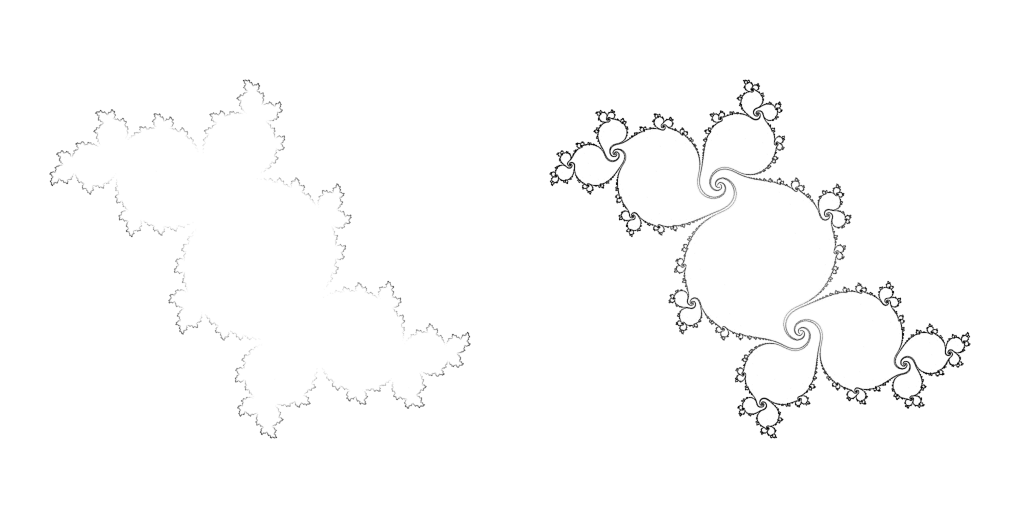

In [20]:
c = -0.11 + 0.65569999 * 1j
r_iim = numba_julia_set_count(c, 1000000)
r_miim = numba_julia_set_count_miim(c, 1000000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
axes[0].imshow(np.log10(r_iim + 1), cmap="gray_r")
axes[1].imshow(r_miim, cmap="gray_r")
for ax in axes:
    ax.set_aspect("equal")
    ax.axis("off")